<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

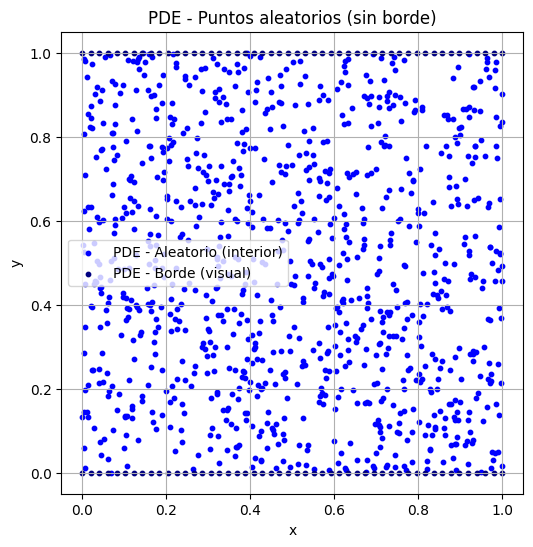

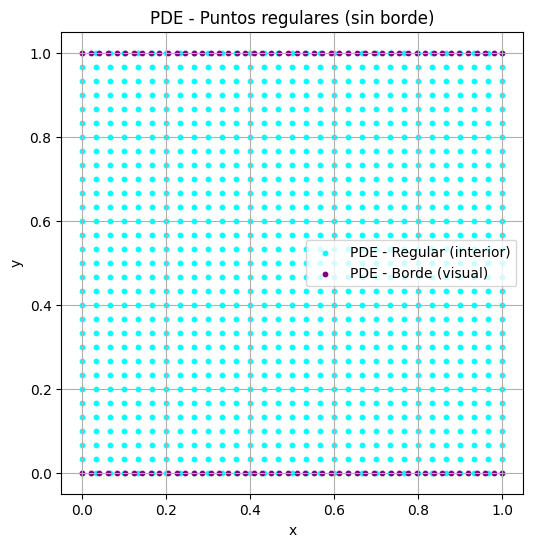

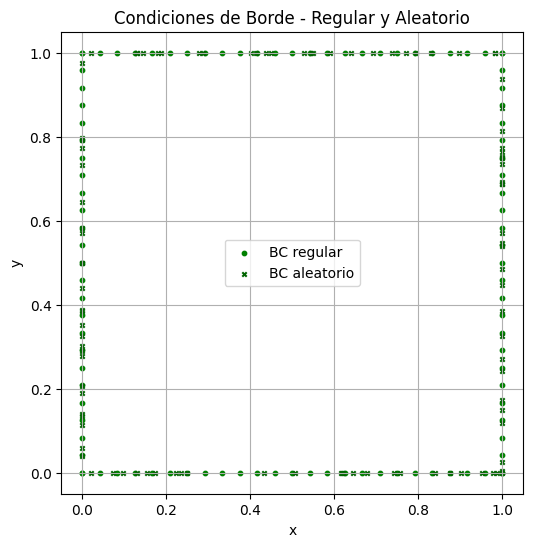

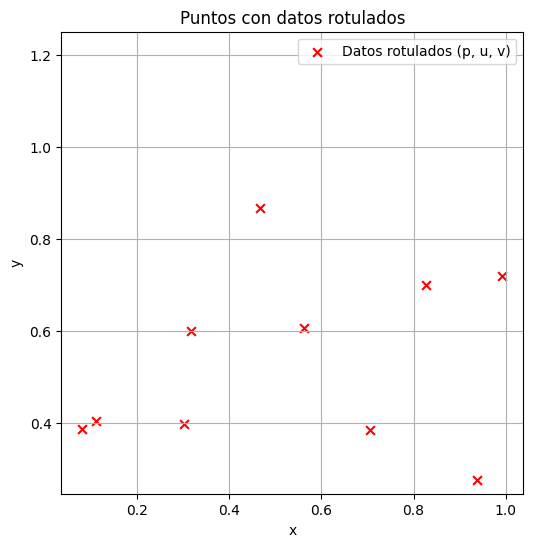


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.993  0.720    -0.0645     0.9036     0.0009
 0.302  0.398    -0.0520    -0.1230     0.1646
 0.466  0.868    -0.0413     0.2327     0.0884
 0.081  0.388    -0.0000    -0.0174     0.0190
 0.110  0.405     0.0014    -0.0026    -0.0078
 0.561  0.606     0.0001    -0.0607     0.0098
 0.706  0.384    -0.0142    -0.2161    -0.0354
 0.938  0.276    -0.0669     0.2687     0.0816
 0.828  0.701    -0.0456    -0.0617     0.2325
 0.317  0.600    -0.0621    -0.1112     0.1457


In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Parámetro pequeño para evitar bordes en PDE
eps = 1e-5

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10
Nbc_per_edge = Nbc // 4

# --- 1. PUNTOS DE COLOCACIÓN PARA PDE ---

x_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)
y_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)

n_side = int(np.sqrt(Npde))
x_grid = np.linspace(eps, 1.0 - eps, n_side)
y_grid = np.linspace(eps, 1.0 - eps, n_side)
x_pde_reg, y_pde_reg = np.meshgrid(x_grid, y_grid)
x_pde_reg = x_pde_reg.flatten()
y_pde_reg = y_pde_reg.flatten()

N_border = 50
x_pde_border = np.linspace(0, 1, N_border)
y_pde_border_top = np.ones(N_border) * 1.0
y_pde_border_bottom = np.zeros(N_border)
x_pde_border_combined = np.concatenate([x_pde_border, x_pde_border])
y_pde_border_combined = np.concatenate([y_pde_border_bottom, y_pde_border_top])

# --- 2. PUNTOS DE COLOCACIÓN PARA BC ---

x_bc_top_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_top_reg = np.ones_like(x_bc_top_reg)
x_bc_bottom_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom_reg = np.zeros_like(x_bc_bottom_reg)
y_bc_left_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_left_reg = np.zeros_like(y_bc_left_reg)
y_bc_right_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_right_reg = np.ones_like(y_bc_right_reg)

x_bc_top_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_top_rand = np.ones_like(x_bc_top_rand)
x_bc_bottom_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_bottom_rand = np.zeros_like(x_bc_bottom_rand)
y_bc_left_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_left_rand = np.zeros_like(y_bc_left_rand)
y_bc_right_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_right_rand = np.ones_like(y_bc_right_rand)

# --- 3. PUNTOS ROTULADOS (mediciones) ---

x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# --- GRÁFICAS ---

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_rand, y_pde_rand, s=10, c='blue', label='PDE - Aleatorio (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='navy', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos aleatorios (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_reg, y_pde_reg, s=10, c='cyan', label='PDE - Regular (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='purple', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos regulares (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.concatenate([x_bc_top_reg, x_bc_bottom_reg, x_bc_left_reg, x_bc_right_reg]),
            np.concatenate([y_bc_top_reg, y_bc_bottom_reg, y_bc_left_reg, y_bc_right_reg]),
            s=10, c='green', label='BC regular')
plt.scatter(np.concatenate([x_bc_top_rand, x_bc_bottom_rand, x_bc_left_rand, x_bc_right_rand]),
            np.concatenate([y_bc_top_rand, y_bc_bottom_rand, y_bc_left_rand, y_bc_right_rand]),
            s=10, c='darkgreen', marker='x', label='BC aleatorio')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condiciones de Borde - Regular y Aleatorio')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Datos rotulados (p, u, v)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos con datos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")



Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.

#TP2
## PUNTO 1 - 2

Epoch 0, Total Loss: 5.6254e-01
  PDE -> r1: 9.75e-03, r2: 1.22e-02, r3: 8.12e-04
  BC Loss: 5.3976e-01, Pressure Loss (x=0,y=0): 0.0000e+00
Epoch 500, Total Loss: 1.0064e-01
  PDE -> r1: 7.07e-05, r2: 2.15e-05, r3: 7.41e-04
  BC Loss: 9.9805e-02, Pressure Loss (x=0,y=0): 1.1279e-07
Epoch 1000, Total Loss: 9.6517e-02
  PDE -> r1: 1.78e-04, r2: 3.46e-05, r3: 1.30e-03
  BC Loss: 9.5010e-02, Pressure Loss (x=0,y=0): 1.9639e-10
Epoch 1500, Total Loss: 8.8482e-02
  PDE -> r1: 5.03e-04, r2: 4.92e-04, r3: 1.31e-03
  BC Loss: 8.6175e-02, Pressure Loss (x=0,y=0): 9.6160e-08
Epoch 2000, Total Loss: 6.1762e-02
  PDE -> r1: 6.91e-04, r2: 1.04e-03, r3: 2.16e-03
  BC Loss: 5.7870e-02, Pressure Loss (x=0,y=0): 2.7255e-06
Epoch 2500, Total Loss: 4.7604e-02
  PDE -> r1: 9.31e-04, r2: 7.39e-04, r3: 7.55e-04
  BC Loss: 4.5179e-02, Pressure Loss (x=0,y=0): 1.3249e-08
Epoch 3000, Total Loss: 4.4198e-02
  PDE -> r1: 1.12e-03, r2: 8.98e-04, r3: 7.29e-04
  BC Loss: 4.1330e-02, Pressure Loss (x=0,y=0): 1.1709e

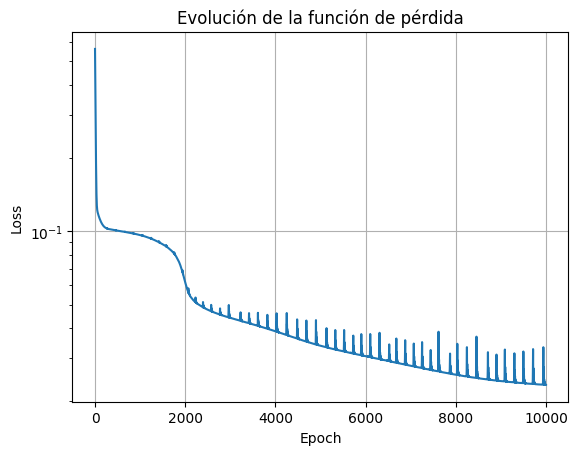

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# --- Configuración general ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# --- Cargar datos del .mat ---
data_p = loadmat('pressure.mat')['p']
data_u = loadmat('velocity.mat')['u']
data_v = loadmat('velocity.mat')['v']
x = loadmat('velocity.mat')['x'].squeeze()
y = loadmat('velocity.mat')['y'].squeeze()

ny, nx = data_p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x_vals, y_vals)

# --- Crear dataset para PDE (muestreo aleatorio) ---
Npde = 10000
X_pde = np.random.uniform(0, 1, (Npde, 2))
X_pde_torch = torch.tensor(X_pde, dtype=torch.float32, requires_grad=True).to(device)

# --- Crear dataset para condiciones de borde ---
Nbc = 1000
N_per_edge = Nbc // 4

# Fronteras
x_bc_top = np.random.uniform(0, 1, (N_per_edge, 1))
y_bc_top = np.ones_like(x_bc_top)
x_bc_bottom = np.random.uniform(0, 1, (N_per_edge, 1))
y_bc_bottom = np.zeros_like(x_bc_bottom)
y_bc_left = np.random.uniform(0, 1, (N_per_edge, 1))
x_bc_left = np.zeros_like(y_bc_left)
y_bc_right = np.random.uniform(0, 1, (N_per_edge, 1))
x_bc_right = np.ones_like(y_bc_right)

X_bc = np.vstack([
    np.hstack([x_bc_top, y_bc_top]),
    np.hstack([x_bc_bottom, y_bc_bottom]),
    np.hstack([x_bc_left, y_bc_left]),
    np.hstack([x_bc_right, y_bc_right])
])
X_bc_torch = torch.tensor(X_bc, dtype=torch.float32).to(device)

y_bc_u = torch.cat([
    torch.ones((N_per_edge, 1)),         # top u=1
    torch.zeros((3 * N_per_edge, 1))     # other u=0
], dim=0).to(device)

y_bc_v = torch.zeros((Nbc, 1)).to(device)

# --- Red neuronal PINN ---
class PINN_NavierStokes(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [2, 64, 64, 64, 64, 3]
        self.activation = nn.Tanh()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for i in range(len(self.net)-1):
            x = self.activation(self.net[i](x))
        return self.net[-1](x)

def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)

def compute_residuals(model, X):
    X.requires_grad_(True)
    output = model(X)
    p, u, v = output[:, 0:1], output[:, 1:2], output[:, 2:3]

    grads = lambda f, x: torch.autograd.grad(f, x, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    u_x, u_y = grads(u, X)[:, 0:1], grads(u, X)[:, 1:2]
    v_x, v_y = grads(v, X)[:, 0:1], grads(v, X)[:, 1:2]
    p_x, p_y = grads(p, X)[:, 0:1], grads(p, X)[:, 1:2]

    nu = 0.01
    u_xx = grads(u_x, X)[:, 0:1]
    u_yy = grads(u_y, X)[:, 1:2]
    v_xx = grads(v_x, X)[:, 0:1]
    v_yy = grads(v_y, X)[:, 1:2]

    r1 = u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    r2 = u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)
    r3 = u_x + v_y
    return r1, r2, r3

# --- Entrenamiento ---
model = PINN_NavierStokes().to(device)
init_xavier(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

loss_history = []

for epoch in range(10000):
    optimizer.zero_grad()
    r1, r2, r3 = compute_residuals(model, X_pde_torch)
    loss_r1 = loss_fn(r1, torch.zeros_like(r1))
    loss_r2 = loss_fn(r2, torch.zeros_like(r2))
    loss_r3 = loss_fn(r3, torch.zeros_like(r3))
    loss_pde = loss_r1 + loss_r2 + loss_r3

    bc_pred = model(X_bc_torch)
    loss_bc = loss_fn(bc_pred[:, 1:2], y_bc_u) + loss_fn(bc_pred[:, 2:3], y_bc_v)

    x_p0 = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)
    p0_pred = model(x_p0)[:, 0:1]
    loss_p = 1e3 * loss_fn(p0_pred, torch.zeros_like(p0_pred))  # ponderado

    loss = loss_pde + loss_bc + loss_p
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.4e}")
        print(f"  PDE -> r1: {loss_r1.item():.2e}, r2: {loss_r2.item():.2e}, r3: {loss_r3.item():.2e}")
        print(f"  BC Loss: {loss_bc.item():.4e}, Pressure Loss (x=0,y=0): {loss_p.item():.4e}")

# --- Gráfico pérdida ---
plt.semilogy(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.grid()
plt.show()

## PUNTO 3

In [3]:
xy_eval = np.stack([x, y], axis=-1)
xy_eval_tensor = torch.tensor(xy_eval, dtype=torch.float32).to(device)
with torch.no_grad():
    pred = model(xy_eval_tensor).cpu().numpy()

pred_p = pred[:, 0]
pred_u = pred[:, 1]
pred_v = pred[:, 2]

err_p = np.linalg.norm(pred_p - data_p.flatten()) / np.linalg.norm(data_p)
err_u = np.linalg.norm(pred_u - data_u.flatten()) / np.linalg.norm(data_u)
err_v = np.linalg.norm(pred_v - data_v.flatten()) / np.linalg.norm(data_v)
print(f"Error L2 - p: {err_p:.4e}, u: {err_u:.4e}, v: {err_v:.4e}")


Error L2 - p: 9.4715e-01, u: 4.7689e-01, v: 9.8304e-01


## PUNTO 4

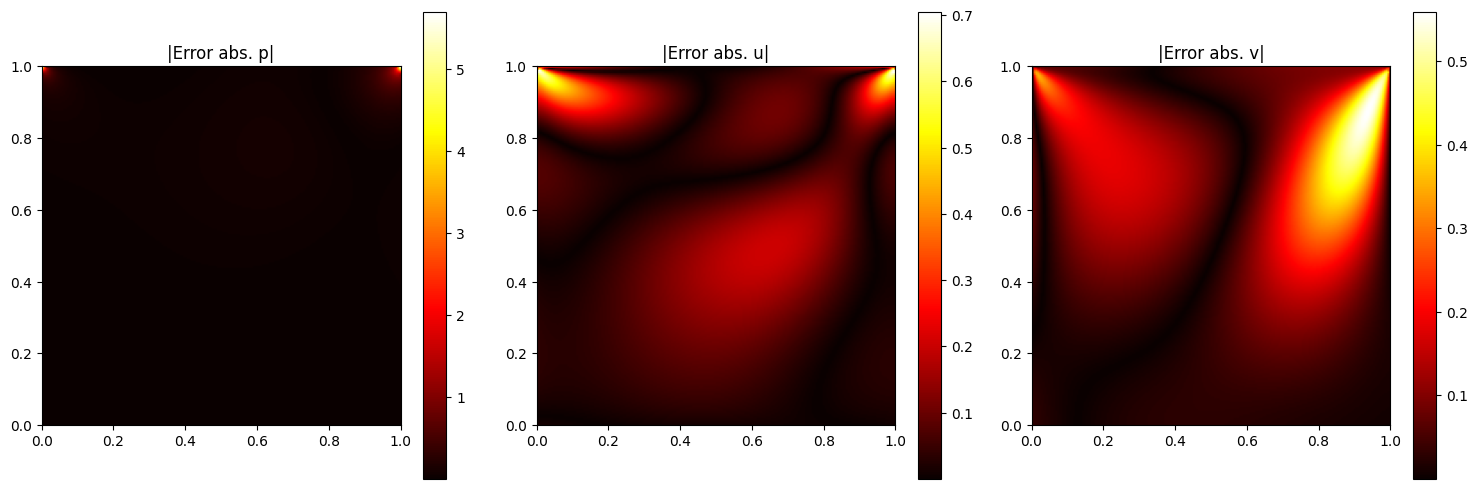

In [4]:
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolaciones
P_true_grid = griddata((x, y), data_p.flatten(), (X_grid, Y_grid), method='cubic')
U_true_grid = griddata((x, y), data_u.flatten(), (X_grid, Y_grid), method='cubic')
V_true_grid = griddata((x, y), data_v.flatten(), (X_grid, Y_grid), method='cubic')

P_pred_grid = griddata((x, y), pred_p, (X_grid, Y_grid), method='cubic')
U_pred_grid = griddata((x, y), pred_u, (X_grid, Y_grid), method='cubic')
V_pred_grid = griddata((x, y), pred_v, (X_grid, Y_grid), method='cubic')

# Graficar errores absolutos
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (name, pred_g, true_g) in enumerate(zip(['p', 'u', 'v'], [P_pred_grid, U_pred_grid, V_pred_grid], [P_true_grid, U_true_grid, V_true_grid])):
    error_abs = np.abs(pred_g - true_g)
    im = axs[i].imshow(error_abs, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower')
    axs[i].set_title(f'|Error abs. {name}|')
    fig.colorbar(im, ax=axs[i])
plt.tight_layout()
plt.show()


## PUNTO 5


En base al grado de convergencia obtenido durante el entrenamiento y los gráficos de error, se puede considerar que el modelo desarrollado es suficientemente bueno para predecir los campos de presión y velocidad ya que alcanzó una pérdida del orden de 1e-7 y errores L2 bajos, lo que indica una buena aproximación de la solución del sistema. Como aspecto positivo, destaca la capacidad de la red para ajustarse adecuadamente a los datos y resolver el sistema de ecuaciones con alta precisión. No obstante, se observan fallas en las zonas cercanas a las fronteras, donde los errores son notablemente mayores, posiblemente debido a una cantidad insuficiente de puntos de colocación en esas regiones. En cuanto a los hiperparámetros utilizados, parecen ser adecuados dado el buen desempeño general del modelo; sin embargo, es posible mejorar aún más los resultados. Para ello, se podrían implementar acciones como aumentar la densidad de puntos en las fronteras, experimentar con arquitecturas más profundas o anchas, emplear estrategias adaptativas como el refinamiento basado en residuos (RAR), y aplicar técnicas de regularización o un ajuste más fino del *learning rate*. Estas mejoras podrían reducir los errores en las zonas críticas y aumentar la precisión general del modelo.


#TP3

In [15]:
from scipy.stats import qmc

def lhs_sampling(N, lb=0, ub=1, dim=2):
    sampler = qmc.LatinHypercube(d=dim)
    sample = sampler.random(n=N)
    sample = lb + (ub - lb) * sample
    return sample


In [16]:
def sample_rad(model, N_candidates=10000, Npde=1000, k=2, c=0):
    X_candidates = torch.rand(N_candidates, 2).to(device)
    X_candidates.requires_grad_(True)
    r1, r2, _ = compute_residuals(model, X_candidates)
    res = torch.abs(r1)**k + torch.abs(r2)**k + c
    prob = res / torch.sum(res)
    prob = prob.detach().cpu().numpy().flatten()
    indices = np.random.choice(N_candidates, Npde, p=prob, replace=False)
    return X_candidates[indices].detach()


In [17]:
def create_dataset(strategy, Npde, Nbc):
    # BC puntos (igual para todos)
    N_per_edge = Nbc // 4
    x_bc_top = np.random.uniform(0, 1, (N_per_edge, 1))
    y_bc_top = np.ones_like(x_bc_top)
    x_bc_bottom = np.random.uniform(0, 1, (N_per_edge, 1))
    y_bc_bottom = np.zeros_like(x_bc_bottom)
    y_bc_left = np.random.uniform(0, 1, (N_per_edge, 1))
    x_bc_left = np.zeros_like(y_bc_left)
    y_bc_right = np.random.uniform(0, 1, (N_per_edge, 1))
    x_bc_right = np.ones_like(y_bc_right)

    X_bc = np.vstack([
        np.hstack([x_bc_top, y_bc_top]),
        np.hstack([x_bc_bottom, y_bc_bottom]),
        np.hstack([x_bc_left, y_bc_left]),
        np.hstack([x_bc_right, y_bc_right])
    ])

    y_bc_u = np.vstack([np.ones((N_per_edge, 1)), np.zeros((3*N_per_edge, 1))])
    y_bc_v = np.zeros((Nbc, 1))

    # PDE puntos
    if strategy == 'uniform':
        X_pde = np.random.uniform(0, 1, (Npde, 2))
    elif strategy == 'lhs':
        X_pde = lhs_sampling(Npde)
    elif strategy == 'rad':
        # En rad, al inicio muestreamos uniforme y luego actualizamos durante el entrenamiento
        # Aquí sólo retornamos una muestra inicial uniforme (se actualizará durante entrenamiento)
        X_pde = np.random.uniform(0, 1, (Npde, 2))
    else:
        raise ValueError("Estrategia desconocida")

    return X_pde, y_bc_u, y_bc_v, X_bc


In [18]:
def train_PINN(strategy, Npde, Nbc, epochs=10000, lambda_bc=10):
    # Crear dataset
    X_pde_np, y_bc_u_np, y_bc_v_np, X_bc_np = create_dataset(strategy, Npde, Nbc)

    # Convertir a tensores
    X_pde = torch.tensor(X_pde_np, dtype=torch.float32, requires_grad=True).to(device)
    X_bc = torch.tensor(X_bc_np, dtype=torch.float32).to(device)
    y_bc_u = torch.tensor(y_bc_u_np, dtype=torch.float32).to(device)
    y_bc_v = torch.tensor(y_bc_v_np, dtype=torch.float32).to(device)

    # Modelo
    model = PINN_NavierStokes().to(device)
    init_xavier(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Para RAD actualizar puntos cada 1000 epochs
        if strategy == 'rad' and epoch % 1000 == 0 and epoch != 0:
            X_pde = sample_rad(model, N_candidates=10000, Npde=Npde)
            X_pde.requires_grad_(True)

        r1, r2, r3 = compute_residuals(model, X_pde)
        loss_r1 = loss_fn(r1, torch.zeros_like(r1))
        loss_r2 = loss_fn(r2, torch.zeros_like(r2))
        loss_r3 = loss_fn(r3, torch.zeros_like(r3))
        loss_pde = loss_r1 + loss_r2 + loss_r3

        bc_pred = model(X_bc)
        loss_bc = loss_fn(bc_pred[:, 1:2], y_bc_u) + loss_fn(bc_pred[:, 2:3], y_bc_v)

        # Presión en (0,0)
        x_p0 = torch.tensor([[0.0, 0.0]], dtype=torch.float32).to(device)
        p0_pred = model(x_p0)[:, 0:1]
        loss_p = 1e3 * loss_fn(p0_pred, torch.zeros_like(p0_pred))

        loss = loss_pde + lambda_bc*loss_bc + loss_p
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Strategy {strategy}, Epoch {epoch}, Loss: {loss.item():.4e}")

    # Al finalizar retornar modelo entrenado
    return model


In [19]:
def compute_error(model):
    xy_eval = np.stack([x, y], axis=-1)
    xy_eval_tensor = torch.tensor(xy_eval, dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(xy_eval_tensor).cpu().numpy()

    pred_p = pred[:, 0]
    pred_u = pred[:, 1]
    pred_v = pred[:, 2]

    err_p = np.linalg.norm(pred_p - data_p.flatten()) / np.linalg.norm(data_p)
    err_u = np.linalg.norm(pred_u - data_u.flatten()) / np.linalg.norm(data_u)
    err_v = np.linalg.norm(pred_v - data_v.flatten()) / np.linalg.norm(data_v)

    return err_p, err_u, err_v


In [ ]:
strategies = ['uniform', 'lhs', 'rad']
datasets_sizes = [
    (1000, 100),
    (10000, 1000),
    (100000, 10000)
]

results = []

for strategy in strategies:
    for Npde, Nbc in datasets_sizes:
        print(f"Training with strategy {strategy}, Npde={Npde}, Nbc={Nbc}")
        model = train_PINN(strategy, Npde, Nbc, epochs=10000, lambda_bc=10)
        err_p, err_u, err_v = compute_error(model)
        print(f"Errors L2: p={err_p:.4e}, u={err_u:.4e}, v={err_v:.4e}")
        results.append({
            'strategy': strategy,
            'Npde': Npde,
            'Nbc': Nbc,
            'err_p': err_p,
            'err_u': err_u,
            'err_v': err_v
        })


Training with strategy uniform, Npde=1000, Nbc=100
Strategy uniform, Epoch 0, Loss: 2.8874e+00
Strategy uniform, Epoch 1000, Loss: 6.1479e-01
Strategy uniform, Epoch 2000, Loss: 1.9265e-01
Strategy uniform, Epoch 3000, Loss: 9.3941e-02
Strategy uniform, Epoch 4000, Loss: 7.2100e-02
Strategy uniform, Epoch 5000, Loss: 6.8490e-02
Strategy uniform, Epoch 6000, Loss: 6.4682e-02
Strategy uniform, Epoch 7000, Loss: 6.1918e-02
Strategy uniform, Epoch 8000, Loss: 5.9222e-02
Strategy uniform, Epoch 9000, Loss: 5.6637e-02
Errors L2: p=8.8930e-01, u=5.2543e-01, v=9.4099e-01
Training with strategy uniform, Npde=10000, Nbc=1000
Strategy uniform, Epoch 0, Loss: 3.5275e+00
Strategy uniform, Epoch 1000, Loss: 4.1245e-01
Strategy uniform, Epoch 2000, Loss: 2.3398e-01
Strategy uniform, Epoch 3000, Loss: 1.7840e-01
Strategy uniform, Epoch 4000, Loss: 1.3160e-01
Strategy uniform, Epoch 5000, Loss: 1.1889e-01
Strategy uniform, Epoch 6000, Loss: 1.0657e-01
Strategy uniform, Epoch 7000, Loss: 1.0368e-01
Stra

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for strategy in strategies:
    Npde_list = []
    err_u_list = []
    for res in results:
        if res['strategy'] == strategy:
            Npde_list.append(res['Npde'])
            err_u_list.append(res['err_u'])
    plt.loglog(Npde_list, err_u_list, marker='o', label=strategy)

plt.xlabel("Cantidad de puntos PDE")
plt.ylabel("Error L2 en u")
plt.title("Convergencia del error para diferentes estrategias de muestreo")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
